In [1]:
import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import time

jax.config.update("jax_platform_name", "cpu")


## generate training trajectories
- 30 trajectories, time step 0.01, final time 0.2, initial states uniform [-2,2]^2

In [2]:
dt = 0.01
T_final = 0.2
NUM_TRAJS = 30
NUM_STEPS = T_final // dt
SEED = 777

key = jr.PRNGKey(SEED)
key, subkey_model, subkey_tr, subkey_tt = jr.split(key, num=4)
initial_states = jr.uniform(subkey_tr, (NUM_TRAJS, 2), minval=jnp.array([-2, -2]), maxval=jnp.array([2,2])) # uniform [-2,2]^2

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



W0000 00:00:1763314801.430108 20333701 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1763314801.444973 20333701 service.cc:145] XLA service 0x10664dc70 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763314801.444984 20333701 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1763314801.446561 20333701 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1763314801.446575 20333701 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


In [3]:
a, b, tau, I = 0.7, 0.8, 12.5, 0.5 # params

# define fitzhugh-nagumo ode
def f(x):
    v,w = x[0], x[1]
    return jnp.array([
        v - v**3 / 3 - w + I,
        (1/tau) * (v + a - b * w)
    ])

In [4]:
def rollout_fn(f, n, dt, include_init: bool = False):
    def scan_fn(u, _):
        # RK 45 Numerical Integrator
        k1 = dt * f(u)
        k2 = dt * f(u + 0.5*k1)
        k3 = dt * f(u + 0.5*k2)
        k4 = dt * f(u + k3)
        u_next = u + (k1 + 2*k2 + 2*k3 + k4) / 6
        return u_next, u_next

    def rollout_fn(u_0):
        _, trj = jax.lax.scan(scan_fn, u_0, None, length=n)

        if include_init:
            return jnp.concatenate([jnp.expand_dims(u_0, axis=0), trj], axis=0)

        return trj

    return rollout_fn

In [5]:
RK45_integrator = lambda x: rollout_fn(f, NUM_STEPS, dt, include_init=True)(x)
trajectories = vmap(RK45_integrator)(initial_states)
print(f"trajectories are shape (n, t, (v,w)) = {trajectories.shape}")

trajectories are shape (n, t, (v,w)) = (30, 21, 2)


(21, 2)


Text(0, 0.5, 'w')

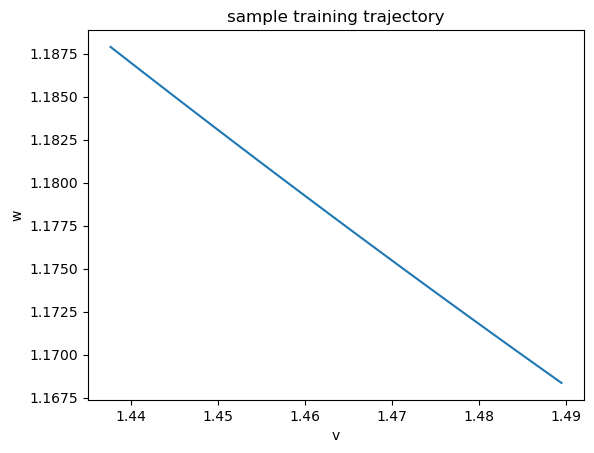

In [6]:
sample_traj = trajectories[0,:,:]
print(sample_traj.shape)
plt.plot(sample_traj[:,0], sample_traj[:,1])
plt.title("sample training trajectory")
plt.xlabel("v")
plt.ylabel("w")

In [7]:
jnp.save("training_traj_rk45.npy", trajectories, allow_pickle = True)

## generate testing data
- 300 trajectories, time step 0.01, final time 400, initial states uniform [-2,2]^2

In [ ]:
dt_test = 0.01
T_final_test = 400
NUM_TRAJS_TEST = 300
NUM_STEPS_TEST = T_final_test // dt_test

key = jr.PRNGKey(SEED)
key, subkey_model_test, subkey_tr_test, subkey_tt_test = jr.split(key, num=4)
initial_states_test = jr.uniform(subkey_tr_test, (NUM_TRAJS_TEST, 2), minval=jnp.array([-2, -2]), maxval=jnp.array([2,2])) # uniform [-2,2]^2

In [9]:
RK45_integrator_test = lambda x: rollout_fn(f, NUM_STEPS_TEST, dt_test, include_init=True)(x)
trajectories_test = vmap(RK45_integrator_test)(initial_states_test)
print(f"test trajectories are shape (n, t, (v,w)) = {trajectories_test.shape}")

test trajectories are shape (n, t, (v,w)) = (300, 40000, 2)


(40000, 2)


Text(0, 0.5, 'w')

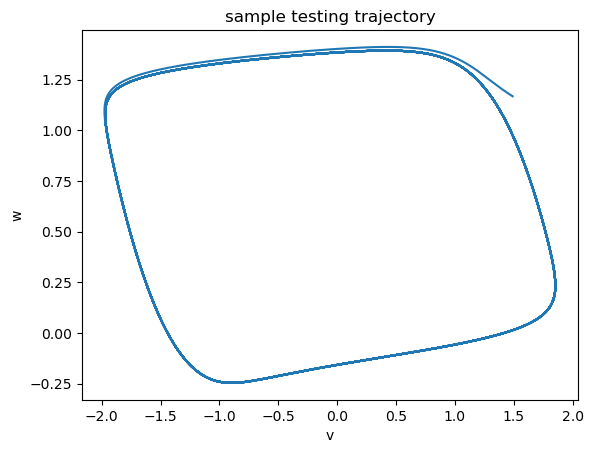

In [10]:
sample_traj_test = trajectories_test[0,:,:]
print(sample_traj_test.shape)
plt.plot(sample_traj_test[:,0], sample_traj_test[:,1])
plt.title("sample testing trajectory")
plt.xlabel("v")
plt.ylabel("w")

In [11]:
jnp.save("testing_traj_rk45.npy", trajectories_test, allow_pickle = True)